## 1. Importing the libraries.

In [1]:
from datetime import datetime as dt
global start 
start = dt.now()

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np

import re
import string

from tqdm import tqdm
import os

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout, BatchNormalization
from keras.models import Model


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Using TensorFlow backend.


## 2. Loading the data and displaying the initial tables.

In [2]:
#Load the given dataframes.
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
#Display the contents of "train_data.csv"
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


In [4]:
#Display the contents of "resources.csv"
resource_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


## 3. Merge the two dataframes based on ID

In [5]:
#Merging both the dataframes by their corresponding IDs
price_quantity_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_quantity_data, on='id', how='left')

#Remove the columns which are not needed anymore. Keeping ID for now.
project_data.drop(['Unnamed: 0', 'teacher_id', 'id'], axis=1, inplace=True)

project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna('Mrs.')
project_data['school_state'] = project_data['school_state'].fillna(' ')
project_data['project_grade_category'] = project_data['project_grade_category'].fillna(' ')
project_data['project_subject_categories'] = project_data['project_subject_categories'].fillna(' ')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].fillna(' ')
project_data['project_title'] = project_data['project_title'].fillna(' ')
project_data['project_essay_1'] = project_data['project_essay_1'].fillna(' ')
project_data['project_essay_2'] = project_data['project_essay_2'].fillna(' ')
project_data['project_essay_3'] = project_data['project_essay_3'].fillna(' ')
project_data['project_essay_4'] = project_data['project_essay_4'].fillna(' ')
project_data['project_resource_summary'] = project_data['project_resource_summary'].fillna(' ')
project_data['teacher_number_of_previously_posted_projects'] = project_data['teacher_number_of_previously_posted_projects'].fillna(0)
project_data['price'] = project_data['price'].fillna(0)
project_data['quantity'] = project_data['quantity'].fillna(0)

project_data.head(3)

,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
0,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",,,My students need opportunities to practice beg...,0,0,154.60,23
1,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,,,My students need a projector to help with view...,7,1,299.00,1
2,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,,,"My students need shine guards, athletic socks,...",1,0,516.85,22


## 4. Basic information about the dataset.

In [6]:
print("Number of data points we have: ", project_data.shape[0])
print("Number of initial features we have:", project_data.shape[1]) 
print("\nLet's look at the all columns present in the dataset: \n",project_data.columns.values)

Number of data points we have:  109248
Number of initial features we have: 16

Let's look at the all columns present in the dataset: 
 ['teacher_prefix' 'school_state' 'project_submitted_datetime'
 'project_grade_category' 'project_subject_categories'
 'project_subject_subcategories' 'project_title' 'project_essay_1'
 'project_essay_2' 'project_essay_3' 'project_essay_4'
 'project_resource_summary' 'teacher_number_of_previously_posted_projects'
 'project_is_approved' 'price' 'quantity']


# 5. Data Pre-processing Section

In this section, we will pre-process all the data before using them to build Machine Learning models. The dataset has the following types of features:

<b>Categorical variables:</b>

1. teacher_prefix
2. school_state
3. project_grade_category
4. project_subject_categories
5. project_subject_subcategories

<b>Text data:</b>

1. project_essay_1
2. project_essay_2
3. project_essay_3
4. project_essay_4
5. project_title
6. project_resource_summary

<b>Numerical Data:</b>

1. teacher_number_of_previously_posted_projects
2. price
3. quantity

### 5.1 Utility functions for pre processing text datas and categories data

In [7]:
#Stopwords contains the list of commonly found english keywords. We will remove them from the text datas as part of the pre-processing of data.
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s", \
            't','u','v','w','x','y','z']

from tqdm import tqdm
def clean_subjects(input_values):
    '''This function will be used to pre process the two features -> "project_subject_categories" and 
    "project_subject_subcategories"'''
    processed_list = []
    for i in tqdm(input_values):
        temp = ""
        for j in i.split(','):
            if 'The' in j.split(): 
                j=j.replace('The','') 
            j = j.replace(' ','') 
            temp +=j.strip()+" "
            temp = temp.replace('&','_')
        processed_list.append(temp.strip())
    return processed_list

import re
def decontracted(phrase):
    """This function will be used to expand the de-contracted words"""
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def process_text(list_of_sentences):
    """This function will be used to pre-process the text data"""
    preprocessed_texts = []
    for sentence in tqdm(list_of_sentences):
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(word.lower() for word in sent.split() if word.lower() not in stopwords) #We will keep only those words in title which has a string length greater than one
        preprocessed_texts.append(sent.lower().strip())
    return preprocessed_texts

### 5.2 Pre-Processing the 'essays' data

In [8]:
#Merging the essays data into one single column for ease of processing.
project_data["essay"] = project_data["project_essay_1"].map(str) + \
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

preprocessed_essays = process_text(project_data["essay"].values)

#Add the pre-processed data into a new column.
project_data['clean_essays'] = preprocessed_essays

#Remove the columns which are already processed and are not needed anymore.
project_data.drop(['essay','project_essay_1','project_essay_2','project_essay_3','project_essay_4'], 
                  axis=1, inplace=True)

100%|██████████| 109248/109248 [02:00<00:00, 905.36it/s]


### 5.3 Pre-Processing the 'project_resource_summary' data

In [9]:
preprocessed_summary = process_text(project_data['project_resource_summary'].values)
project_data['clean_project_resource_summary'] = preprocessed_summary
project_data.drop(['project_resource_summary'], axis=1, inplace=True)

100%|██████████| 109248/109248 [00:12<00:00, 8621.78it/s]


### 5.4 Pre-Processing the 'project_title' data

In [10]:
preprocessed_titles = process_text(project_data['project_title'].values)
project_data['clean_project_title'] = preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)

100%|██████████| 109248/109248 [00:05<00:00, 19912.64it/s]


### 5.5 Pre-Processing of 'project_subject_categories'

In [11]:
preprocessed_categories = clean_subjects(project_data['project_subject_categories'].values)

project_data['clean_categories'] = preprocessed_categories
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

100%|██████████| 109248/109248 [00:00<00:00, 302094.48it/s]


### 5.6 Pre-Processing of 'project_subject_subcategories'

In [12]:
preprocessed_subcategories = clean_subjects(project_data['project_subject_subcategories'].values)

project_data['clean_subcategories'] = preprocessed_subcategories
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

100%|██████████| 109248/109248 [00:00<00:00, 301790.06it/s]


### 5.7 Pre-Processing of 'project_grade_category'

In [13]:
project_data['project_grade_category'] = project_data['project_grade_category'].map(lambda x: x.replace(" ","_").replace("-","_"))

### 5.7 Designing a new feature called - Presence of numerical digits in project resources summary

In [14]:
def is_digit(sent):
    digits=re.findall('\d+', sent)
    if(len(digits) != 0 ):
        return 1
    else:
        return 0

project_data['presence_of_the_numerical_digits']=project_data['clean_project_resource_summary'].apply(is_digit)

### 5.8 Combining all text features into one single feature 'total_text'

In [15]:
project_data['total_text'] = project_data['clean_essays'].map(str) + " " + project_data['clean_project_resource_summary'].map(str) + " " + project_data['clean_project_title'].map(str)
project_data.drop(['clean_essays','clean_project_resource_summary','clean_project_title','project_submitted_datetime'], axis=1, inplace=True) #Remove not needed features

### 5.9 Replacing NAN values by empty strings 

In [16]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna('Mrs.')

### 5.10 Display the processed dataframe and save it into a pandas CSV file.

In [17]:
#After pre-processing, we have 13 features. We will have one feature as our target variable and the rest of the columns as our independent features variables.
project_data.head(5)

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_categories,clean_subcategories,presence_of_the_numerical_digits,total_text
0,Mrs.,IN,Grades_PreK_2,0,0,154.60,23,Literacy_Language,ESL Literacy,0,students english learners working english seco...
1,Mr.,FL,Grades_6_8,7,1,299.00,1,History_Civics Health_Sports,Civics_Government TeamSports,0,students arrive school eager learn polite gene...
2,Ms.,AZ,Grades_6_8,1,0,516.85,22,Health_Sports,Health_Wellness TeamSports,0,true champions not always ones win guts mia ha...
3,Mrs.,KY,Grades_PreK_2,4,1,232.90,4,Literacy_Language Math_Science,Literacy Mathematics,0,work unique school filled esl english second l...
4,Mrs.,TX,Grades_PreK_2,1,1,67.98,4,Math_Science,Mathematics,0,second grade classroom next year made around 2...


In [18]:
#Save the processed dataset into a pandas CSV file.
project_data.to_csv("processed_data.csv", index=False)

In [2]:
project_data = pd.read_csv("processed_data.csv")

## 6. Splitting the original data into train and test data in 80:20 ratio.

In [3]:
#Taking the target and predictor variables into separate variables
y = project_data["project_is_approved"] #target variables
X = project_data.drop(['project_is_approved'], axis=1) #predictor variables

#Split the dataset into train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

#Display basic information after splitting the data
print("Number of points in train data: ",X_train.shape[0])
print("Number of points in validation data: ",X_test.shape[0])

Number of points in train data:  87398
Number of points in validation data:  21850


# Model 1

## Total Text Data

### Build train and test data

In [4]:
#Get the total_text values in list
docs_text_train=list(X_train.total_text.values)
docs_text_test=list(X_test.total_text.values)
labels_train=np.array(y_train)
labels_test=np.array(y_test)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_text_train)

#Convert the texts to sequences using the tokenizer
sequences_text_train = tokens.texts_to_sequences(docs_text_train)
sequences_text_test = tokens.texts_to_sequences(docs_text_test)
vocab_size_text = len(tokens.word_index) + 1

#Add padding
padded_text_train = pad_sequences(sequences_text_train, maxlen=300, padding='post')
padded_text_test = pad_sequences(sequences_text_test, maxlen=300, padding='post')

In [5]:
#Load the whole embedding into memory
embeddings_index = dict()
file = open('glove.6B.300d.txt')
for line in file:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

#Create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size_text, 300))
for word, i in tqdm(tokens.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector #embedding_matrix.shape: (9049, 300)

print(len(embedding_matrix[0]))

100%|██████████| 55638/55638 [00:00<00:00, 301621.03it/s]

Loaded 400000 word vectors.
300


In [6]:
#Get the flattened LSTM output for input text
input_layer_total_text = Input(shape=(300,), name = "total_text_sequence")
embedding_layer_total_text = Embedding(input_dim=vocab_size_text, output_dim=300, weights=[embedding_matrix], trainable=False)(input_layer_total_text)
lstm_total_text  = LSTM(16, activation="relu", return_sequences=True)(embedding_layer_total_text)
flatten_total_text = Flatten()(lstm_total_text)

Instructions for updating:
Colocations handled automatically by placer.


## Categorical data: school_state 

### Building train and test data

In [7]:
#Get the school state values
docs_school_state_train=list(X_train.school_state.values)
docs_school_state_test=list(X_test.school_state.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_school_state_train)

#Convert the school_state to sequences using the tokenizer
sequences_school_train = np.array(tokens.texts_to_sequences(docs_school_state_train))
sequences_school_test = np.array(tokens.texts_to_sequences(docs_school_state_test))
vocab_size_school_state = len(tokens.word_index) + 1

In [8]:
#Get the flattened output for school_state
input_layer_school_state = Input(shape=(1,), name = "encoded_school_state")
embedding_layer_school_state = Embedding(input_dim=vocab_size_school_state, output_dim=4, trainable=True)(input_layer_school_state)
flatten_school_state = Flatten()(embedding_layer_school_state)

## Categorical data: teacher_prefix 

### Building train and test data

In [9]:
#Get the teacher_prefix values
docs_teacher_prefix_train=list(X_train.teacher_prefix.values)
docs_teacher_prefix_test=list(X_test.teacher_prefix.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_teacher_prefix_train)

#Convert the school_state to sequences using the tokenizer
sequences_teacher_prefix_train = np.array(tokens.texts_to_sequences(docs_teacher_prefix_train))
sequences_teacher_prefix_test = np.array(tokens.texts_to_sequences(docs_teacher_prefix_test))
vocab_size_teacher_prefix = len(tokens.word_index) + 1

In [10]:
# teacher_prefix
input_layer_teacher_prefix = Input(shape=(1,), name = "teacher_prefix")
embedding_layer_teacher_prefix = Embedding(input_dim=vocab_size_teacher_prefix, output_dim=4, trainable=True)(input_layer_teacher_prefix)
flatten_teacher_prefix = Flatten()(embedding_layer_teacher_prefix)

## Categorical data: project_grade_category 

### Building train and test data

In [11]:
#Get the project_grade_category values
docs_project_grade_category_train=list(X_train.project_grade_category.values)
docs_project_grade_category_test=list(X_test.project_grade_category.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_project_grade_category_train)

#Convert the school_state to sequences using the tokenizer
sequences_project_grade_category_train = tokens.texts_to_sequences(docs_project_grade_category_train)
sequences_project_grade_category_test = tokens.texts_to_sequences(docs_project_grade_category_test)
vocab_size_project_grade_category= len(tokens.word_index) + 1

#Add padding
padded_project_grade_category_train = pad_sequences(sequences_project_grade_category_train, maxlen=3, padding='post')
padded_project_grade_category_test = pad_sequences(sequences_project_grade_category_test, maxlen=3, padding='post')

In [12]:
# project_grade_category
input_layer_project_grade = Input(shape=(3,), name = "project_grade_category")
embedding_layer_project_grade = Embedding(input_dim=vocab_size_project_grade_category, output_dim=4, trainable=True)(input_layer_project_grade)
flatten_project_grade = Flatten()(embedding_layer_project_grade)

## Categorical data: clean_categories

### Building train and test data

In [13]:
#Get the clean_categories values
docs_clean_categories_train=list(X_train.clean_categories.values)
docs_clean_categories_test=list(X_test.clean_categories.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_clean_categories_train)

#Convert the school_state to sequences using the tokenizer
sequences_clean_categories_train = tokens.texts_to_sequences(docs_clean_categories_train)
sequences_clean_categories_test = tokens.texts_to_sequences(docs_clean_categories_test)
vocab_size_clean_categories = len(tokens.word_index) + 1

#Add padding
padded_clean_categories_train = pad_sequences(sequences_clean_categories_train, maxlen=3, padding='post')
padded_clean_categories_test = pad_sequences(sequences_clean_categories_test, maxlen=3, padding='post')

In [14]:
#clean_categories
input_layer_clean_categories = Input(shape=(3,), name = "clean_categories")
embedding_layer_clean_categories = Embedding(input_dim=vocab_size_clean_categories, output_dim=4, trainable=True)(input_layer_clean_categories)
flatten_clean_categories = Flatten()(embedding_layer_clean_categories)

## Categorical data: clean_subcategories

### Building train and test data

In [15]:
#Get the clean_subcategories values
docs_clean_subcategories_train=list(X_train.clean_subcategories.values)
docs_clean_subcategories_test=list(X_test.clean_subcategories.values)

#Initializing the keras tokenizer and fitting it on train data
tokens = Tokenizer()
tokens.fit_on_texts(docs_clean_subcategories_train)

#Convert the school_state to sequences using the tokenizer
sequences_clean_subcategories_train = tokens.texts_to_sequences(docs_clean_subcategories_train)
sequences_clean_subcategories_test = tokens.texts_to_sequences(docs_clean_subcategories_test)
vocab_size_clean_subcategories = len(tokens.word_index) + 1

padded_clean_subcategories_train = pad_sequences(sequences_clean_subcategories_train, maxlen=3, padding='post')
padded_clean_subcategories_test = pad_sequences(sequences_clean_subcategories_test, maxlen=3, padding='post')

In [16]:
# clean_subcategories
input_layer_clean_subcategories = Input(shape=(3,), name = "clean_subcategories")
embedding_layer_clean_subcategories = Embedding(input_dim=vocab_size_clean_subcategories, output_dim=4, trainable=True)(input_layer_clean_subcategories)
flatten_clean_subcategories = Flatten()(embedding_layer_clean_subcategories)

## Numerical datas

In [17]:
from sklearn.preprocessing import Normalizer

def normalize_vars(data):
    """This function is used to normalize all the input datas between 0 and 1"""
    normalizer = Normalizer()
    data_normalized = normalizer.fit_transform(data.reshape(1, -1))
    return data_normalized, normalizer

## teacher_number_of_previously_posted_projects

### Building train and test data

In [18]:
previous_projects_train = X_train.teacher_number_of_previously_posted_projects.values
previous_projects_test = X_test.teacher_number_of_previously_posted_projects.values

norm_previous_projects_train, normalizer = normalize_vars(previous_projects_train.reshape(1,-1))
norm_previous_projects_test = normalizer.transform(previous_projects_test.reshape(1,-1))

norm_previous_projects_train = norm_previous_projects_train.reshape(len(X_train),1)
norm_previous_projects_test = norm_previous_projects_test.reshape(len(X_test),1)

In [19]:
input_layer_previous_projects = Input(shape=(1,), name = "previous_projects")

## price

### Building train and test data

In [20]:
price_train = X_train.price.values
price_test = X_test.price.values

norm_price_train, normalizer = normalize_vars(price_train.reshape(1,-1))
norm_price_test = normalizer.transform(price_test.reshape(1,-1))

norm_price_train = norm_price_train.reshape(len(X_train),1)
norm_price_test = norm_price_test.reshape(len(X_test),1)

In [21]:
input_layer_price = Input(shape=(1,), name = "price")

## quantity

### Building train and test data

In [22]:
quantity_train = X_train.quantity.values
quantity_test = X_test.quantity.values

norm_quantity_train, normalizer = normalize_vars(quantity_train.reshape(1,-1))
norm_quantity_test = normalizer.transform(quantity_test.reshape(1,-1))

norm_quantity_train = norm_quantity_train.reshape(len(X_train),1)
norm_quantity_test = norm_quantity_test.reshape(len(X_test),1)

In [23]:
input_layer_quantity = Input(shape=(1,), name = "quantity")

### Concatenation of all the numerical features layers

In [24]:
numerical_features_layers_concat = concatenate([input_layer_previous_projects, input_layer_price, input_layer_quantity])
dense_layer_numerical = Dense(4, activation='relu',kernel_initializer='he_normal')(numerical_features_layers_concat)

### Concatenation of all the layers and building the final model

In [25]:
# Merge all the layers according to the architecture diagram
x = concatenate([flatten_total_text, flatten_teacher_prefix, flatten_school_state, flatten_project_grade, flatten_clean_categories, flatten_clean_subcategories, dense_layer_numerical])
x = Dense(8, activation='relu',kernel_initializer='he_normal', name='dense_layer_1')(x)
x = Dropout(0.6, name='dropout_1')(x)
x = Dense(4, activation='relu',kernel_initializer='he_normal',name='dense_layer_2')(x)
x = Dropout(0.6, name='dropout_2')(x)
output_layer = Dense(1, activation='sigmoid', name='output_layer')(x)

# Final model
model = Model(inputs=[input_layer_total_text,input_layer_teacher_prefix,input_layer_school_state,input_layer_project_grade,input_layer_clean_categories,
                      input_layer_clean_subcategories,input_layer_previous_projects,input_layer_price,input_layer_quantity], outputs=[output_layer])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
total_text_sequence (InputLayer (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     16691700    total_text_sequence[0][0]        
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
encoded_school_state (InputLaye (None, 1)            0                                       

### Defining a custom metric AUC

In [26]:
from sklearn import metrics as sklm
import tensorflow as tf
def auc_roc(y_true, y_pred):
    return tf.py_func(sklm.roc_auc_score, (y_true, y_pred), tf.double)

import keras
#https://stackoverflow.com/questions/51922500/tf-metrics-auc-yielding-very-different-from-sklearn-metrics-roc-auc-score
def roc_auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    keras.backend.get_session().run(tf.local_variables_initializer())
    return auc

### Defining a callbacks

In [31]:
from time import time
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping
tensorboard = TensorBoard(log_dir="logs/{}".format(time))
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

### Compiling the final model

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[roc_auc])
model.fit(x=[padded_text_train,sequences_teacher_prefix_train,sequences_school_train,padded_project_grade_category_train,padded_clean_categories_train,padded_clean_subcategories_train,
             norm_previous_projects_train,norm_price_train,norm_quantity_train], 
          y=[labels_train],
          validation_data=([padded_text_test,sequences_teacher_prefix_test,sequences_school_test,padded_project_grade_category_test,padded_clean_categories_test,padded_clean_subcategories_test,
                            norm_previous_projects_test,norm_price_test,norm_quantity_test],[labels_test]),
          epochs=50, 
          batch_size=1024, 
          callbacks=[tensorboard,early_stop])

Train on 87398 samples, validate on 21850 samples
Epoch 1/50
87398/87398 [==============================] - 140s 2ms/step - loss: 0.5275 - roc_auc: 0.5134 - val_loss: 0.4492 - val_roc_auc: 0.5350
Epoch 2/50
87398/87398 [==============================] - 134s 2ms/step - loss: 0.4905 - roc_auc: 0.5507 - val_loss: 0.4232 - val_roc_auc: 0.5634
Epoch 3/50
87398/87398 [==============================] - 135s 2ms/step - loss: 0.4702 - roc_auc: 0.5720 - val_loss: 0.3959 - val_roc_auc: 0.5801
Epoch 4/50
87398/87398 [==============================] - 134s 2ms/step - loss: 0.4548 - roc_auc: 0.5868 - val_loss: 0.3864 - val_roc_auc: 0.5926
Epoch 5/50
87398/87398 [==============================] - 133s 2ms/step - loss: 0.4452 - roc_auc: 0.5971 - val_loss: 0.3948 - val_roc_auc: 0.6008
Epoch 6/50
87398/87398 [==============================] - 133s 2ms/step - loss: 0.4354 - roc_auc: 0.6043 - val_loss: 0.3848 - val_roc_auc: 0.6077
Epoch 7/50
17408/87398 [====>.........................] - ETA: 1:33 - loss

In [ ]:
!tensorboard --logdir=logs/

# Model 2

1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)

### TF-IDF Analysis

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Fit the TFIDF vectorizer to the train data
vect = TfidfVectorizer()
vect.fit_transform(X_train['total_text'])

#Get the features names and their corresponding IDF scores
words = vect.get_feature_names()
idf_words = vect.idf_

#Map the words and their idf_ scores in a disctionary
dict_word_idf_ = dict(zip(words, idf_words))

### Box-Plot Analysis

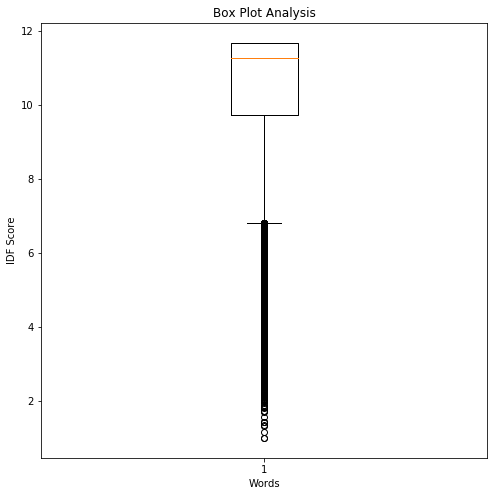

The lowest significant value of TF-IDF Scores:  9.739181790315316
The highest significant value of TF-IDF Scores:  11.685091939370627


In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.boxplot(idf_words)
plt.title('Box Plot Analysis')
plt.xlabel('Words')
plt.ylabel('IDF Score')
plt.show()

p_25th = np.percentile(idf_words,25)
p_75th = np.percentile(idf_words,75)

print("The lowest significant value of TF-IDF Scores: ",p_25th)
print("The highest significant value of TF-IDF Scores: ",p_75th)

### Create a list of words to be removed

In [34]:
removed_wordlist = []
for word in list(dict_word_idf_.keys()):
    if(dict_word_idf_[word] < p_25th or dict_word_idf_[word] > p_75th):
        removed_wordlist.append(word)
    else:
        continue
        
print("Number of words to be removed: ",len(removed_wordlist))

Number of words to be removed:  13786
